In [1]:
## env: py37

from itertools import product
import pickle
import os
import bdpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
import seaborn as sns
import pandas 
import pdb
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage
from sklearn import linear_model
from bdpy.util import makedir_ifnot
from bdpy.ml import cvindex_groupwise
from bdpy.preproc import select_top, average_sample, reduce_outlier, regressout, shift_sample
from bdpy.dataform import append_dataframe
from sklearn.metrics import mean_squared_error

In [2]:
def preprocess(dat_track):
    dat_track = dat_track.dropna(subset=['time'])
    dat_track = dat_track[dat_track["trial_type"] == 5.0]
    return dat_track

# def pixel2angle(x, axis):
#     # to transfer eyetracker data to visual angle 
#     # resolution:1024,768; screen size:433., 325.mm
#     if axis == "x": 
#         distance_x = (x-512)*433/1024 
#         ang_x = np.degrees(np.arctan(distance_x/1096))
#     else:
#         # distance_x = (384-x)*280/768 #wrong! up side down
#         distance_x = (x-384)*325/768   
#         ang_x = np.degrees(np.arctan(distance_x/1096))
#     return ang_x

# def angle2pixel(x, axis):
#     # to transfer eyetracker data to visual angle 
#     # resolution:1024,768; screen size:433., 325.mm
#     if axis == "x": 
#         distance_x = (x-512)*433/1024 
#         ang_x = np.degrees(np.arctan(distance_x/1096))
#     else:
#         # distance_x = (384-x)*280/768 #wrong! up side down
#         distance_x = (x-384)*325/768   
#         ang_x = np.degrees(np.arctan(distance_x/1096))
#     return ang_x

In [4]:
results_dir = '/home/kiss/data/fmri_shared/eyetracker/YS210128'
# analysis_name = 'eye_movement_train_OpenEye_test_ClosedEye.py'
results_file = os.path.join(results_dir, 'YS210128_ses01_run01.pkl')

with open(results_file, 'rb') as f:
    dat_track1 = pickle.load(f)
dat_track1 = preprocess(dat_track1)

In [5]:
dat_track1

,time_n,trigger,pos_x,pos_y,pupil,trial_type,fixation_point_position_x,fixation_point_position_y,direction,eye_closed,dense_fp,time,fp_pos_pix_x,fp_pos_pix_y
1920,210055,0,438.5,239.6,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.000000,832.740314,702.725098
1921,210056,0,444.4,244.9,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.016667,832.740314,702.725098
1922,210057,0,440.3,242.7,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.033333,832.740314,702.725098
1923,210058,0,440.3,245.0,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.050000,832.740314,702.725098
1924,210059,0,439.2,249.3,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.066667,832.740314,702.725098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13915,222050,0,126.8,286.3,4.0,5.0,-7.0,0.0,0.0,0.0,1.0,231.916667,191.259686,384.000000
13916,222051,0,130.1,284.6,3.9,5.0,-7.0,0.0,0.0,0.0,1.0,231.933333,191.259686,384.000000
13917,222052,0,131.4,277.2,4.0,5.0,-7.0,0.0,0.0,0.0,1.0,231.950000,191.259686,384.000000
13918,222053,0,133.5,288.0,4.0,5.0,-7.0,0.0,0.0,0.0,1.0,231.966667,191.259686,384.000000


In [6]:
results_dir = '/home/kiss/data/fmri_shared/eyetracker/YS210128'
# analysis_name = 'eye_movement_train_OpenEye_test_ClosedEye.py'
results_file = os.path.join(results_dir, 'YS210128_ses01_run02.pkl')

with open(results_file, 'rb') as f:
    dat_track2 = pickle.load(f)
dat_track2 = preprocess(dat_track2)
dat_track2

,time_n,trigger,pos_x,pos_y,pupil,trial_type,fixation_point_position_x,fixation_point_position_y,direction,eye_closed,dense_fp,time,fp_pos_pix_x,fp_pos_pix_y
1920,227736,0,493.5,296.8,4.5,5.0,-3.5,-7.0,0.0,0.0,1.0,32.000000,351.629843,65.274902
1921,227737,0,488.9,289.3,4.6,5.0,-3.5,-7.0,0.0,0.0,1.0,32.016667,351.629843,65.274902
1922,227738,0,483.1,299.0,4.5,5.0,-3.5,-7.0,0.0,0.0,1.0,32.033333,351.629843,65.274902
1923,227739,0,492.0,289.3,4.5,5.0,-3.5,-7.0,0.0,0.0,1.0,32.050000,351.629843,65.274902
1924,227740,0,489.3,286.5,4.5,5.0,-3.5,-7.0,0.0,0.0,1.0,32.066667,351.629843,65.274902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13915,239731,0,141.0,604.1,4.0,5.0,-7.0,7.0,0.0,0.0,1.0,231.916667,191.259686,702.725098
13916,239732,0,137.7,595.1,4.1,5.0,-7.0,7.0,0.0,0.0,1.0,231.933333,191.259686,702.725098
13917,239733,0,137.0,592.9,4.0,5.0,-7.0,7.0,0.0,0.0,1.0,231.950000,191.259686,702.725098
13918,239734,0,140.1,599.5,4.0,5.0,-7.0,7.0,0.0,0.0,1.0,231.966667,191.259686,702.725098


In [7]:
dat = pd.concat( [dat_track1, dat_track2], axis=0 )
dat

,time_n,trigger,pos_x,pos_y,pupil,trial_type,fixation_point_position_x,fixation_point_position_y,direction,eye_closed,dense_fp,time,fp_pos_pix_x,fp_pos_pix_y
1920,210055,0,438.5,239.6,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.000000,832.740314,702.725098
1921,210056,0,444.4,244.9,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.016667,832.740314,702.725098
1922,210057,0,440.3,242.7,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.033333,832.740314,702.725098
1923,210058,0,440.3,245.0,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.050000,832.740314,702.725098
1924,210059,0,439.2,249.3,3.3,5.0,7.0,7.0,0.0,0.0,1.0,32.066667,832.740314,702.725098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13915,239731,0,141.0,604.1,4.0,5.0,-7.0,7.0,0.0,0.0,1.0,231.916667,191.259686,702.725098
13916,239732,0,137.7,595.1,4.1,5.0,-7.0,7.0,0.0,0.0,1.0,231.933333,191.259686,702.725098
13917,239733,0,137.0,592.9,4.0,5.0,-7.0,7.0,0.0,0.0,1.0,231.950000,191.259686,702.725098
13918,239734,0,140.1,599.5,4.0,5.0,-7.0,7.0,0.0,0.0,1.0,231.966667,191.259686,702.725098


In [8]:

#         classification_acc = []
#         classification_acc_tr = []

x_train = []
x_test = []
y_train = []
y_test = []

x_train = dat['pos_x']
# x_train = x_train.reshape(-1, 1)
y_train = dat['fp_pos_pix_x']

model = linear_model.Lasso(alpha=0.1)
#             model.fit(x_train, y_train.astype('int'))
model.fit(x_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

filename = 'correction_model_x.sav'
pickle.dump(model, open(filename, 'wb'))

In [9]:
x_train = []
x_test = []
y_train = []
y_test = []

x_train = dat['pos_y']
# x_train = x_train.reshape(-1, 1)
y_train = dat['fp_pos_pix_y']

model = linear_model.Lasso(alpha=0.1)
#             model.fit(x_train, y_train.astype('int'))
model.fit(x_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

filename = 'correction_model_y.sav'
pickle.dump(model, open(filename, 'wb'))

In [10]:
def correct_run(dat1, dat2):
    x_train = dat1['pos_x']
    # x_train = x_train.reshape(-1, 1)
    y_train = dat1['fp_pos_pix_x']

    model_x = linear_model.Lasso(alpha=0.1)
    #             model.fit(x_train, y_train.astype('int'))
    model_x.fit(x_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

    # filename = 'correction_model_x.sav'
    # pickle.dump(model, open(filename, 'wb'))
    x_test = dat2['pos_x']
    x_corrected = model_x.predict(x_test.values.reshape(-1, 1))
    dat2['pos_x'] = x_corrected

    x_train = dat1['pos_y']
    # x_train = x_train.reshape(-1, 1)
    y_train = dat1['fp_pos_pix_y']

    model_y = linear_model.Lasso(alpha=0.1)
    #             model.fit(x_train, y_train.astype('int'))
    model_y.fit(x_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

    # filename = 'correction_model_x.sav'
    # pickle.dump(model, open(filename, 'wb'))
    x_test = dat2['pos_y']
    x_corrected = model_x.predict(x_test.values.reshape(-1, 1))
    dat2['pos_y'] = x_corrected
    
    return dat2

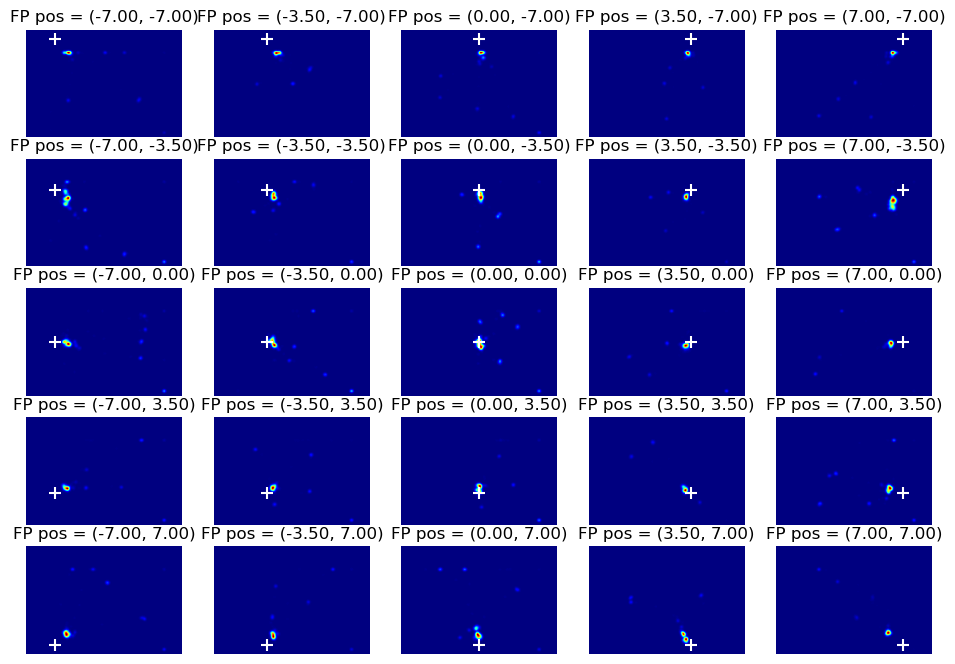

In [11]:
# Make heat maps for each FP position
data = correct_run(dat_track1, dat_track2)

fp_pos_all=[]
fp_pos = [(row['fixation_point_position_x'],
                   row['fixation_point_position_y'],
                   row['fp_pos_pix_x'],
                   row['fp_pos_pix_y'])
          for i, row in data.iterrows() if not np.isnan(row['fixation_point_position_x']) and 
          not np.isnan(row['fixation_point_position_y'])]
fp_pos_all=fp_pos_all+fp_pos
fp_poss = set(fp_pos_all)
len(fp_pos_all)

fig = plt.figure(figsize=(11.69, 8.27), dpi=100)

for fp_pos in fp_poss:
    data_tmp = data.loc[(data['fixation_point_position_x'] == fp_pos[0]) &
                        (data['fixation_point_position_y'] == fp_pos[1])]

    bin_size = 1
    x = np.arange(0, 1024 // bin_size, 1) + 1
    y = np.arange(0, 768 // bin_size, 1) + 1

    x_mesh, y_mesh = np.meshgrid(x, y)
    eye_pos_dense = np.zeros((768 // bin_size, 1024 // bin_size)) # Y axis dir: Up-to-down

    for epx, epy in zip(np.round(data_tmp['pos_x']), np.round(data_tmp['pos_y'])):
        if not 0 < epx < 1024: continue
        if not 0 < epy < 768: continue
#         eye_pos_dense[int(epy / bin_size) - 1, int(epx / bin_size) - 1] += 1
#         print('epx, epy:',epx, epy)
#         print('after:',int(768 - epy / bin_size) - 1, int(epx / bin_size) - 1)
        eye_pos_dense[int(768 - epy / bin_size) - 1, int(epx / bin_size) - 1] += 1
    

    eye_pos_dense = ndimage.gaussian_filter(eye_pos_dense, sigma=8)

#     subplot_pos = fp_pos[0] / 3 + 3 + (- fp_pos[1] / 3 + 2) * 5
    subplot_pos = fp_pos[0] / 3.5 + 3 + (fp_pos[1] / 3.5 + 2) * 5
    plt.subplot(5, 5, subplot_pos)

    plt.pcolormesh(x_mesh, y_mesh, eye_pos_dense, cmap='jet')
#     plt.scatter(fp_pos[2], fp_pos[3], marker='+', s=64, c='white')
    plt.scatter(fp_pos[2], 768 - fp_pos[3], marker='+', s=64, c='white')
    plt.title('FP pos = (%.2f, %.2f)' % (fp_pos[0], fp_pos[1]))
    plt.axis('off')


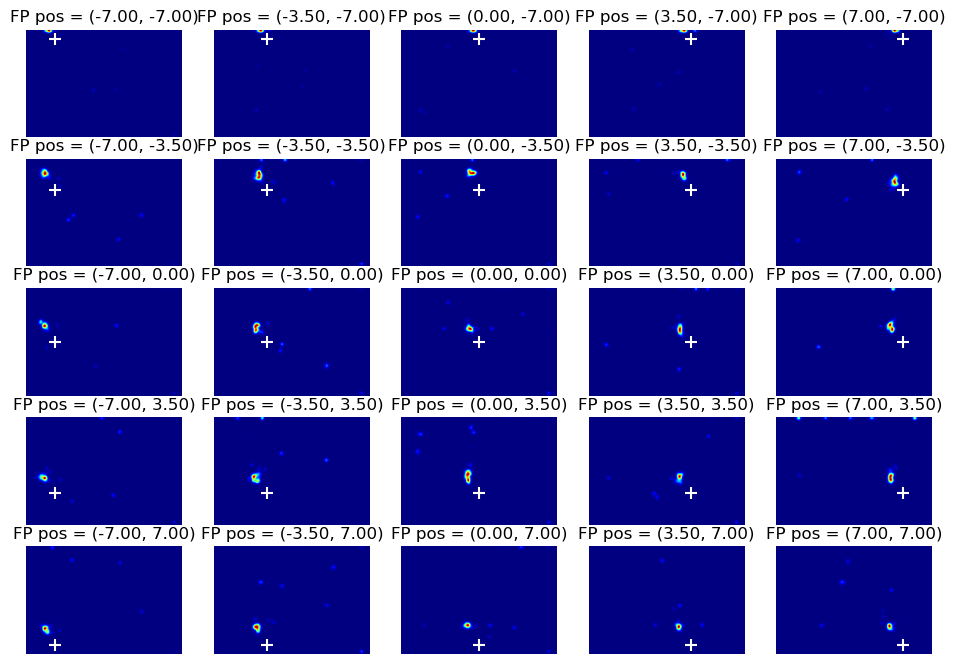

In [12]:
# Make heat maps for each FP position
data = correct_run(dat_track2, dat_track1)

fp_pos_all=[]
fp_pos = [(row['fixation_point_position_x'],
                   row['fixation_point_position_y'],
                   row['fp_pos_pix_x'],
                   row['fp_pos_pix_y'])
          for i, row in data.iterrows() if not np.isnan(row['fixation_point_position_x']) and 
          not np.isnan(row['fixation_point_position_y'])]
fp_pos_all=fp_pos_all+fp_pos
fp_poss = set(fp_pos_all)
len(fp_pos_all)

fig = plt.figure(figsize=(11.69, 8.27), dpi=100)

for fp_pos in fp_poss:
    data_tmp = data.loc[(data['fixation_point_position_x'] == fp_pos[0]) &
                        (data['fixation_point_position_y'] == fp_pos[1])]

    bin_size = 1
    x = np.arange(0, 1024 // bin_size, 1) + 1
    y = np.arange(0, 768 // bin_size, 1) + 1

    x_mesh, y_mesh = np.meshgrid(x, y)
    eye_pos_dense = np.zeros((768 // bin_size, 1024 // bin_size)) # Y axis dir: Up-to-down

    for epx, epy in zip(np.round(data_tmp['pos_x']), np.round(data_tmp['pos_y'])):
        if not 0 < epx < 1024: continue
        if not 0 < epy < 768: continue
#         eye_pos_dense[int(epy / bin_size) - 1, int(epx / bin_size) - 1] += 1
#         print('epx, epy:',epx, epy)
#         print('after:',int(768 - epy / bin_size) - 1, int(epx / bin_size) - 1)
        eye_pos_dense[int(768 - epy / bin_size) - 1, int(epx / bin_size) - 1] += 1
    

    eye_pos_dense = ndimage.gaussian_filter(eye_pos_dense, sigma=8)

#     subplot_pos = fp_pos[0] / 3 + 3 + (- fp_pos[1] / 3 + 2) * 5
    subplot_pos = fp_pos[0] / 3.5 + 3 + (fp_pos[1] / 3.5 + 2) * 5
    plt.subplot(5, 5, subplot_pos)

    plt.pcolormesh(x_mesh, y_mesh, eye_pos_dense, cmap='jet')
#     plt.scatter(fp_pos[2], fp_pos[3], marker='+', s=64, c='white')
    plt.scatter(fp_pos[2], 768 - fp_pos[3], marker='+', s=64, c='white')
    plt.title('FP pos = (%.2f, %.2f)' % (fp_pos[0], fp_pos[1]))
    plt.axis('off')
